## Load the metadata

The metadata pre-processed in notebook 1 contains the id's of the 3D-models that will be downloaded.

In [8]:
import pandas as pd
import os

# reload the cleaned-up data
metadata_df = pd.read_csv(os.path.join('data', 'metadata.csv'), index_col=False)

# keep only cats and dogs
idx = (metadata_df['family'] == 'Canidae') | (metadata_df['family'] == 'Felidae')
metadata_df = metadata_df[idx]

print('There are {} 3D-models in the dataset.'.format(metadata_df.shape[0]))

There are 83 3D-models in the dataset.


## Preprocess 3D-models


To extract the point cloud data from each 3D-model, I applied these steps (detailed in the following notebook cells):

1. sub sample point cloud data so that the number of vertices is the number computed in the EDA in notebook 1, i.e. 37838 vertices
2. render the views as images
3. save the pixel data of the flattened images into a npz file

### Implement functions to decode GLTF files
3D-Models provided by the API are in Graphics Language Transmission Format (glTF). I implemented a function to read this kind of files using the open source [pygltflib library](https://pypi.org/project/pygltflib/).

In [10]:
import zipfile
from pygltflib import GLTF2, BufferFormat
import struct
import numpy as np
import warnings
warnings.filterwarnings("ignore") # the gltf loader raises some unecessary warning
from PIL import Image
from PIL.Image import DecompressionBombError

DOWNLOAD_DIR = '/mnt/Disk2/vertebrate_anatomy_models' # Folder where the downloaded files are stored
TEMP_DIR = '/mnt/Disk2/temp' # Folder to temporarily extract the zipped files

def read_vertices(unzip_dir):
    """
    Reads a model's point cloud
    @param unzip_dir string, path to folder where gltf file was unzipped
    @returns numpy array of all vertices (3D-coordinates) in the 3D-model
    """
    # After unzipping the file, open its "scene" data
    filename = os.path.join(unzip_dir, 'scene.gltf') # the "scene" file is always called scene.gltf
    gltf = GLTF2().load(filename)
    # load the binary data contained in the "scene.bin" file into the gltf object
    gltf.convert_buffers(BufferFormat.DATAURI)

    # get the vertices for each primitive in each mesh
    vertices = []
    for mesh in gltf.meshes:
        for primitive in mesh.primitives:

            # get the binary data for this mesh primitive from the buffer
            accessor = gltf.accessors[primitive.attributes.POSITION]
            bufferView = gltf.bufferViews[accessor.bufferView]
            buffer = gltf.buffers[bufferView.buffer]
            data = gltf.decode_data_uri(buffer.uri)

            # pull each vertex from the binary buffer and convert it into a tuple of python floats
            for i in range(accessor.count):
                index = bufferView.byteOffset + accessor.byteOffset + i*12  # the location in the buffer of this vertex
                d = data[index:index+12]  # the vertex data
                v = struct.unpack("<fff", d)   # convert from base64 to three floats
                vertices.append(v)

    # convert the vertices to a numpy array
    vertices_np = np.array(vertices)
    return vertices_np


def extract_gltf(model_uid):
    """
    Extracts the point cloud data from a gltf file as a numpy array.
    The returned array contains the 3D coordinates of all points in the point cloud.
    @param model_uid, string, id of a model
    @returns a numpy array of 3D coordinates
    """
    try:
        # create a temporary folder to extract this file
        unzip_dir = os.path.join(TEMP_DIR, model_uid)
        os.mkdir(unzip_dir)

        # unzip the downloaded 3D-model
        filename_zipped = os.path.join(DOWNLOAD_DIR, '{}.zip'.format(model_uid)) # zip file containing the the 3D-model
        with zipfile.ZipFile(filename_zipped, 'r') as zip_file:
            zip_file.extractall(unzip_dir)

        # read the model's point cloud
        vertices_np = read_vertices(unzip_dir)
        
        return vertices_np
    
    except DecompressionBombError as error:
        # image fils is too large
        print(error)
        return vertices_np, None
    
    finally:
        # whatever happens, delete the temporary folder
        os.remove(os.path.join(unzip_dir, 'scene.gltf'))
        os.remove(os.path.join(unzip_dir, 'scene.bin'))
        if os.path.isfile(os.path.join(unzip_dir, 'license.txt')):
            os.remove(os.path.join(unzip_dir, 'license.txt'))
        # remove texture
        textures_dir = os.path.join(unzip_dir, 'textures')
        if os.path.isdir(textures_dir): # check that the textures folder exists
            for _,_,files in os.walk(textures_dir):
                for file in files:
                    os.remove(os.path.join(textures_dir, file))
            os.rmdir(textures_dir)
        os.rmdir(unzip_dir)

### Implement a function to sub sample point clouds
3D-models with a large number of vertices (up to several million) have a blotched appearance when rendered. Reducing the number of vertices brings up more detail (notebook 1, fig. 6) and increases processing speed. In notebook 1, I discarded the 5% of models with the least vertices. In this notebook, I sub sampled the vertices in each 3D-model to the minimum number of vertices in the data set prepared in notebook 1.

In [108]:
#MAX_VERTICES = metadata_df['vertexCount'].min() # the lowest vertex count of any model in the dataset
MAX_VERTICES = 20000
print('The 3D-models will be subsampled to {} vertices.'.format(MAX_VERTICES))

def subsample_model(vertices_np):
    """
    Reduces the number of vertices in the 3D-model.
    @param vertices_np np array as returned by extract_gltf()
    @returns np array with MAX_VERTICES vertices
    """
    return pd.DataFrame(vertices_np).sample(n=MAX_VERTICES, random_state=0).to_numpy()

The 3D-models will be subsampled to 20000 vertices.


### Read all downloaded 3D-models

In [109]:
# get a list of all 3D-models that have been downloaded
downloaded_uid = [model_uid for model_uid in metadata_df['id'] if os.path.isfile(os.path.join(DOWNLOAD_DIR, '{}.zip'.format(model_uid)))]
# some models are in several collections, so drop duplicates. Don't convert to set, as set will reorder the entries 
downloaded_uid = list(dict.fromkeys(downloaded_uid).keys())

# read the point cloud and subsample the vertices to MAX_VERTICES
vertices = []
counter = 1
for model_uid in downloaded_uid:
    print('{} ({}/{})'.format(model_uid, counter, len(downloaded_uid)))
    vertices_np = extract_gltf(model_uid)
    vertices_np = subsample_model(vertices_np)
    vertices.append(vertices_np)
    counter += 1

22edbe4be11045b38b1db30e2c369cd7 (1/83)
772291056d3b45ef86c1a91182c720b4 (2/83)
067a3c1c8ebb482693b262b9867ceeb1 (3/83)
276e92326314407d86d2526a8ce3f3a2 (4/83)
9a1b50477ab242c6b3ec5f7ea6258081 (5/83)
cc1203875d184b509046a1092333af57 (6/83)
2c68e0ad39e24a36ade66515e5b05b17 (7/83)
1631af4e14544311a11e55032b010880 (8/83)
8af76d9a281d45e797cbd50dbbb8c0cd (9/83)
b02b74081f9e45389b027c7568799538 (10/83)
6a287f0187a24334a8d0606fef48346e (11/83)
6e525a6837c54e299ae5e86fcdc7f05b (12/83)
06faec763eca46358f985785a9da0657 (13/83)
156fd51e4c4b42c2abbab7d6f4cd6057 (14/83)
be7b2e85ce074876918f607b59bd3724 (15/83)
65d534fa3c35475292facb62f7f31e4c (16/83)
5abb4ba0d8e0405b91e43a22b5fb000b (17/83)
c56ab225657c4976b9ea4e1a116b863b (18/83)
27320c7b3ec84330882b6bd482373fd0 (19/83)
a3d02ff66f7c4979b624e5ce449218f8 (20/83)
5b749e8a3c5742cf8873750b59f62010 (21/83)
0a7bf498ee4d40bf83272b68700e6a47 (22/83)
0c4c74633c824cc89336b6585b5b224c (23/83)
0a89617e6e434db48d231484e51b0aad (24/83)
a0af673b673140f3a374857ca

In [110]:
print('The output of this step is:\n\
    A "vertices" list of {} point clouds ({}), each containing the 3D coordinates of {} points.'.format(
    len(vertices), type(vertices[0]), vertices[0].shape[0]
))

The output of this step is:
    A "vertices" list of 83 point clouds (<class 'numpy.ndarray'>), each containing the 3D coordinates of 20000 points.


In [111]:
# save vertices arrays
NPZ_DIR = '/mnt/Disk2/vertebrate_anatomy_npz_models' # temp files

np.savez_compressed(os.path.join(NPZ_DIR, 'vertices_temp.npz'), 
        downloaded_uid = downloaded_uid,
        vertices = vertices
        )


## Render the views as images
The views have to be rendered to images to use as input for the classifier. The image data has to be of the required size and type. [Inception v3](https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1) will be used. The Tensor Flow documentation states that the [common input format for image-related tasks](https://www.tensorflow.org/hub/common_signatures/images) requires image batches of 299x299 elements of type float32, with 3 color channels, where color values are normalized to [0,1]. However, to keep the file sizes under the limit enforced by GitHub, I stored the data as arrays of uint8 (range 0 - 255), containing 3 color channels.

In [1]:
import numpy as np
import os

NPZ_DIR = '/mnt/Disk2/vertebrate_anatomy_npz_models' # temp files

# Load the numpy .npz file
with np.load(os.path.join(NPZ_DIR, 'vertices_temp.npz'), allow_pickle=True) as data:
    vertices_data = dict(data.items())

downloaded_uid = vertices_data['downloaded_uid']
vertices = vertices_data['vertices']


In [2]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvas
from PIL import Image

def plot_model(ax, point_cloud, aspect_ratio, title=None):
    """
    Plots a point cloud in orthogonal projection (i.e. without perspective), onto a pyplot figure axis.
    @param ax matplotlib axis
    @param point_cloud np array of vertices (x,y,z) coordinates of the input data
    @param aspect_ratio float aspect ratio of the input data
    @param string title, e.g. model identifier
    """
    ax.set_aspect(aspect_ratio)
    ax.scatter(point_cloud[:,0], point_cloud[:,1], s=1, color='black') # plot the x/y coordinates of each vertex
    if title:
        ax.set_title(title)
    ax.axis("off") # don't show axis labels and ticks

def point_cloud_to_array(point_cloud, aspect_ratio, size):
    """
    Plots a np array of point cloud 3D coordinates onto a "hidden" canvas, returns a flat np array of grayscale values.
    @param point_cloud np array of vertices (x,y,z) coordinates of the input data
    @param aspect_ratio float aspect ratio of the input data
    @param size int width and height in pixels of the output image
    @returns flattened np array of grayscale values
    """
    CANVAS_SIZE = 20 # make the canvas larger than the expected output. 20x20 inches is arbitrary, but canvas should be square, as is the output image.
    
    # Create a "hidden" canvas
    ax = Figure(figsize=(CANVAS_SIZE,CANVAS_SIZE)).subplots()
    canvas = FigureCanvas(ax.get_figure())

    # plot the vertices onto "hidden" canvas
    plot_model(ax, point_cloud, aspect_ratio)
    canvas.draw()

    # resize to image size expected by TF model
    img = Image.frombytes('RGB', canvas.get_width_height(),canvas.tostring_rgb()) # convert canvas to PIL Image
    img = img.resize((size,size), Image.BILINEAR)
    
    return(np.array(img).flatten()) # flat np array

In [3]:
TF_SIZE = 299

# Render elevation views
rendered_elevation = []
for idx in range(len(vertices)):
    point_cloud = vertices[idx] # a numpy array of 3D coordinates
    aspect_ratio = 1
    # Render input data to size expected by TF model, as a flat np array of grayscale values
    X = point_cloud_to_array(point_cloud, aspect_ratio, TF_SIZE) 
    rendered_elevation.append(X)
rendered_elevation = np.array(rendered_elevation)

In [4]:
print('The output of this step are: "rendered_elevation" list of {} arrays ({}), \n\
each containing the pixel data of one flattened 299*299, 3-channel image.\n\
Each pixel is represented as an integer ({}) with a value in the range [{}, {}].'.format(
    len(rendered_elevation), type(rendered_elevation[0]), 
    type(rendered_elevation[0][0]), np.min(rendered_elevation[0]), np.max(rendered_elevation[0])
))

The output of this step are: "rendered_elevation" list of 83 arrays (<class 'numpy.ndarray'>), 
each containing the pixel data of one flattened 299*299, 3-channel image.
Each pixel is represented as an integer (<class 'numpy.uint8'>) with a value in the range [0, 255].


### Test rendered views
To check if the previous steps worked well, plot the elevation, plan and section views of randomly selected point clouds. The model's identifier is shown at the bottom.

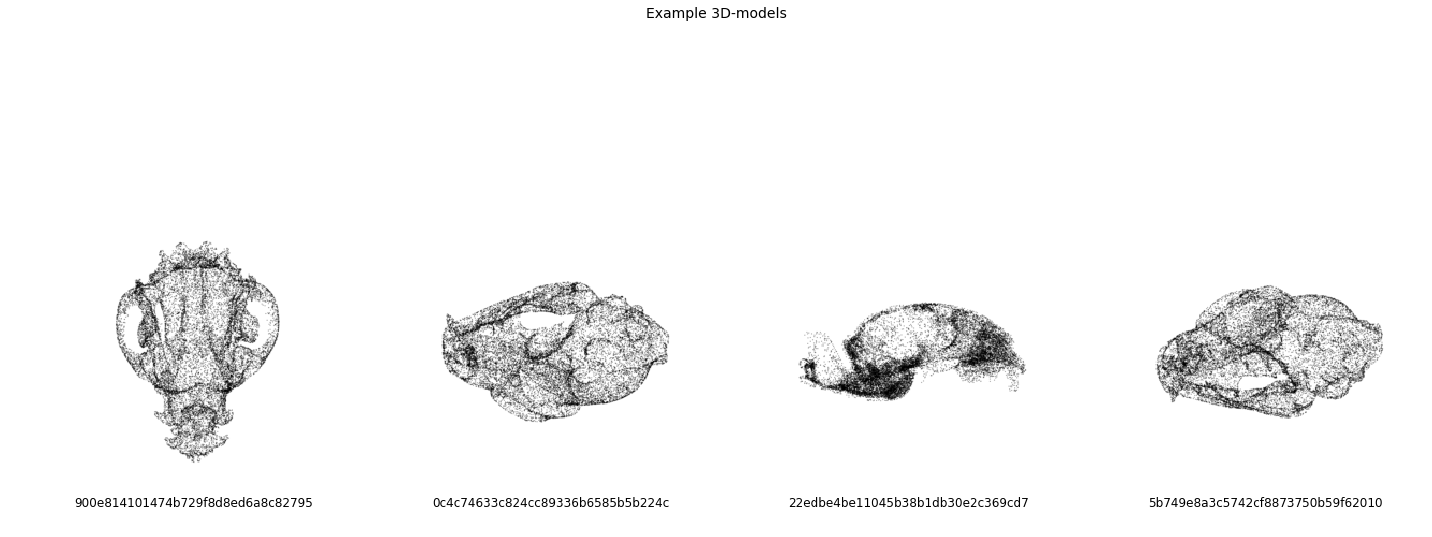

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import random 

# select some 3D-models at random
num_models = 4
fig, ax = plt.subplots(1, num_models, figsize=(20, 10))

for i in range(num_models):
    # select random 3D-model
    idx = random.randrange(len(vertices))
    # elevation views
    ax[i].imshow(rendered_elevation[idx].reshape(299, 299, 3), cmap=plt.cm.gray)
    ax[i].axis('off')
    # show 3D-model id
    model_uid = downloaded_uid[idx] #  a string identifying the model
    ax[i].set_title(model_uid, y=0)
plt.tight_layout()
fig.suptitle('Example 3D-models', fontsize=14)
plt.show();

## Split and save rendered point clouds and textures
The rendered point clouds can now be saved as compressed npz files.

The data is split into training (60%), validation (20%) and test (20%) data, to  prevent overfitting.
The number of items per class is imbalanced (notebook 1, EDA), splitting the dataset takes this into account by setting the stratify parameter to the 'family' (taxonomical family: _Felidae_ or _Canidae_) column.

In [12]:
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

metadata_tr, metadata_te = train_test_split(metadata_df, train_size=0.6, stratify=metadata_df['family'], random_state=0)
metadata_va, metadata_te = train_test_split(metadata_te, train_size=0.5, stratify=metadata_te['family'], random_state=0)
print('The training dataset has {} entries, the validation dataset {}, the testing dataset {}.'.format(len(metadata_tr), len(metadata_va), len(metadata_te)))

The training dataset has 49 entries, the validation dataset 17, the testing dataset 17.


The distribution of items per 'period' class in each dataset are shown in the plot below. Grafically, they apear to be correctly stratified, as expected.

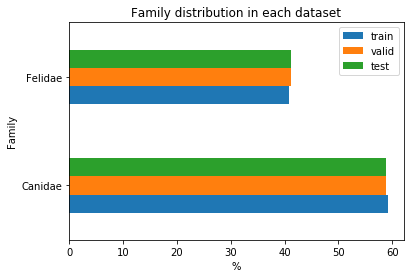

In [14]:
import matplotlib.pyplot as plt

# count items by period
counts = pd.DataFrame()
# training dataset
counts['train'] = 100*metadata_tr['family'].value_counts() / len(metadata_tr)
# validation dataset
counts['valid'] = 100*metadata_va['family'].value_counts() / len(metadata_va)
# testing dataset
counts['test'] = 100*metadata_te['family'].value_counts() / len(metadata_te)

# horizontal bar plot
counts.plot.barh()
plt.xlabel('%')
plt.ylabel('Family')
plt.title('Family distribution in each dataset')
plt.show();

### Directory structure
The train, validation and test datasets can now be saved to compressed npz files.
The `data` directory structure looks like this:
```
test/                   # Test dataset (20%)
- point_clouds.npz
train/                  # Training dataset (60%)
- point_clouds.npz
validate/               # Validation dataset (20%)
- point_clouds.npz
species.csv             # taxonomy
downloaded_metadata.csv # 3D-model metadata as it was obtained from Sketchfab
metadata.csv            # Cleaned-up metadata
```

In [16]:
# TRAIN
TRAIN_DIR = 'data/train'

# filter train data
idx = [uid in list(metadata_tr['id']) for uid in metadata_df['id']]
# save rendered views to compressed file
np.savez_compressed(os.path.join(TRAIN_DIR, 'point_clouds.npz'),
         metadata = metadata_df[idx],
         elevation = rendered_elevation[idx],
        )

# VALIDATE
VALIDATE_DIR = 'data/validate'

# filter validation data
idx = [uid in list(metadata_va['id']) for uid in metadata_df['id']]
# save rendered views to compressed file
np.savez_compressed(os.path.join(VALIDATE_DIR, 'point_clouds.npz'),
         metadata = metadata_df[idx],
         elevation = rendered_elevation[idx],
        )

# TEST
TEST_DIR = 'data/test'

# filter test data
idx = [uid in list(metadata_te['id']) for uid in metadata_df['id']]
# save rendered views to compressed file
np.savez_compressed(os.path.join(TEST_DIR, 'point_clouds.npz'),
         metadata = metadata_df[idx],
         elevation = rendered_elevation[idx],
        )